## 使用 CNN 破解驗證碼

### 下載資料集

In [2]:
! wget https://raw.githubusercontent.com/ywchiu/tibamedl/master/data/captcha_jpg.zip

--2020-05-12 07:07:01--  https://raw.githubusercontent.com/ywchiu/tibamedl/master/data/captcha_jpg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818150 (3.6M) [application/zip]
Saving to: ‘captcha_jpg.zip’

captcha_jpg.zip     100%[===================>]   3.64M  --.-KB/s    in 0.1s    

2020-05-12 07:07:02 (25.7 MB/s) - ‘captcha_jpg.zip’ saved [3818150/3818150]



In [0]:
! unzip captcha_jpg.zip > 1.log

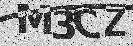

In [4]:
from PIL import Image
Image.open('data/994.jpg')

In [0]:
import pandas
captcha =  pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/output_captua.csv', usecols=['captcua', 'file'])
captcha.columns = ['captcha', 'file']

In [6]:
captcha.tail(6)

,captcha,file
993,m3cz,994.0
994,q93a,995.0
995,r9m5,996.0
996,5n4m,997.0
997,tj94,998.0
998,zhaz,999.0


In [0]:
captcha = captcha[captcha['file'].notnull()]

In [0]:
captcha['file'] = captcha['file'].map(lambda e: 'data/{}.jpg'.format(int(e)) )

In [0]:
captcha.reset_index(inplace=True)
del captcha['index']

In [10]:
#captcha.head()
captcha.tail(6)

,captcha,file
992,m3cz,data/994.jpg
993,q93a,data/995.jpg
994,r9m5,data/996.jpg
995,5n4m,data/997.jpg
996,tj94,data/998.jpg
997,zhaz,data/999.jpg


In [11]:
from PIL import Image
import numpy as np
img = Image.open('data/2.jpg')
img = img.resize((135,47))
#img
im = np.array(img)
im.shape

(47, 135, 3)

### 建立 X 與 Y

In [12]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
height, width = 47,135
n_len = 4
n_class = len(characters)
print(height, width, n_class,n_len)

47 135 36 4


In [13]:
X = np.zeros((len(captcha), height, width, 3), dtype=np.float32)
y = [np.zeros((len(captcha), n_class), dtype=np.uint8) for i in range(n_len)]
X.shape, y[0].shape, len(y)

((998, 47, 135, 3), (998, 36), 4)

In [0]:
for i in captcha.index:
    random_str = captcha.loc[i,'captcha']
    fname = captcha.loc[i,'file']
    img = Image.open(fname)
    img = img.resize((width, height))
    im = np.array(img)
    X[i] = im * 1.0 / 255.0
    for j, ch in enumerate(random_str):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [15]:
y[0][992]
y[1][992]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [0]:
import random
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            rand_index = random.choice(captcha.index)
            random_str = captcha.loc[rand_index,'captcha']
            fname = captcha.loc[rand_index,'file']
            img = Image.open(fname)
            img = img.resize((width, height))
            im = np.array(img)
            X[i] = im / 255.0

            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

### 建立 CNN 模型

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [0]:
input_tensor = Input((height, width, 3))

x = input_tensor
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Conv2D(256, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Flatten()(x)
x = Dropout(0.25)(x)

In [20]:
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 135, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 45, 133, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 43, 131, 64)  36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 21, 65, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                    epochs=5,                # 總共跑5個訓練循環
                    steps_per_epoch=1000,
                    #callbacks=cbks,          # 保存最好的模型到檔案
                    validation_data=gen(),   # 驗證資料也是用生成器來產生
                    validation_steps=40      # 用40組資料來驗證
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
1000/1000 [==============================] - 73s 73ms/step - loss: 2.0259 - c1_loss: 0.4937 - c2_loss: 0.5120 - c3_loss: 0.5010 - c4_loss: 0.5192 - c1_accuracy: 0.8890 - c2_accuracy: 0.8839 - c3_accuracy: 0.8885 - c4_accuracy: 0.8831 - val_loss: 0.4398 - val_c1_loss: 0.1402 - val_c2_loss: 0.1355 - val_c3_loss: 0.0747 - val_c4_loss: 0.0894 - val_c1_accuracy: 0.9719 - val_c2_accuracy: 0.9781 - val_c3_accuracy: 0.9805 - val_c4_accuracy: 0.9852
Epoch 2/5
1000/1000 [==============================] - 73s 73ms/step - loss: 0.7078 - c1_loss: 0.1643 - c2_loss: 0.1820 - c3_loss: 0.1647 - c4_loss: 0.1967 - c1_accuracy: 0.9742 - c2_accuracy: 0.9718 - c3_accuracy: 0.9771 - c4_accuracy: 0.9696 - val_loss: 0.4647 - val_c1_loss: 0.1102 - val_c2_loss: 0.1275 - val_c3_loss: 0.1030 - val_c4_loss: 0.1240 - val_c1_accuracy: 0.9828 - val_c2_accuracy: 0.9773 - val_c3_accuracy: 0.9898 - val_c4_accuracy: 0.9805
Epoch 3/5
 249

KeyboardInterrupt: ignored

In [0]:
model.save('captcha.h5')

In [24]:
import numpy as np
img = Image.open('data/995.jpg')
img = img.resize((135,47))
#img
im = np.array(img)
im.shape
#im

(47, 135, 3)

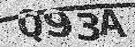

In [25]:
img

In [0]:
X_predict = np.zeros((1, height, width, 3), dtype=np.uint8)
X_predict[0] = im / 255.0

In [27]:
for p in model(X_predict):
  print(characters[(np.argmax(p.numpy()))])

q
9
3
a


In [0]:
import requests
from bs4 import BeautifulSoup
headers2 = {
  'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'  
}

def getCaptcha():
    rs = requests.session()
    res = rs.get('https://irs.thsrc.com.tw/IMINT/', headers = headers2)
    soup = BeautifulSoup(res.text, 'lxml')
    print(res.text)
    domain = 'https://irs.thsrc.com.tw'
    imgsrc = soup.select_one('img#BookingS1Form_homeCaptcha_passCode').get('src')
    imgurl = domain + imgsrc
    res2 = rs.get(imgurl, headers = headers2)
    with open('prediction.jpg', 'wb') as f:
        f.write(res2.content)

In [29]:
getCaptcha()

KeyboardInterrupt: ignored

In [0]:
from PIL import Image
Image.open('prediction.jpg')

In [1]:
! nvidia-smi

Tue May 12 07:06:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 使用LSTM預測股票走勢

### 取得股票價格資訊

In [30]:
import  pandas_datareader
tw2330 = pandas_datareader.DataReader('2330.TW', data_source = 'yahoo')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [31]:
tw2330.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-05-14,148.5,146.0,148.0,146.0,38700000.0,120.068169
2015-05-15,147.0,145.0,147.0,146.5,24295000.0,120.479370
2015-05-18,147.0,145.0,147.0,146.5,22879000.0,120.479370
2015-05-19,147.5,145.0,145.5,146.5,26257000.0,120.479370
2015-05-20,147.0,146.0,146.5,146.5,26920000.0,120.479370


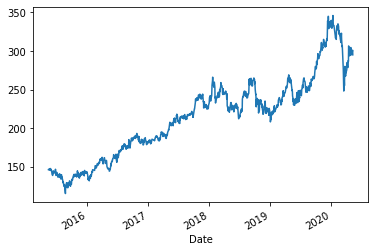

In [32]:
tw2330['Close'].plot(kind = 'line')

In [34]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 6.0MB/s 


In [35]:
from pmdarima import auto_arima
auto_arima(tw2330['Close'],error_action='ignore').summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1219
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3209.386
Date:                Tue, 12 May 2020   AIC                           6430.772
Time:                        07:18:27   BIC                           6461.402
Sample:                             0   HQIC                          6442.302
                               - 1219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.002      1.502      0.133      -0.001       0.007
ar.L1          0.3824      0.308      1.243      0.214      -0.221       0.985
ar.L2          0.5934      0.299      1.983      0.047       0.007       1.180
ma.L1         -0.4320      0.317     -1.363      0.173      -1.053       0.189
ma.L2         -0.5599      0.313     -1.788      0.074      -1.174       0.054
sigma2        11.3503      0.268     42.327      0.000      10.825      11.876
===================================================================================
Ljung-Box (Q):                       79.58   Jarque-Bera (JB):              1002.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.19   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
stepwise_fit = auto_arima(tw2330['Close'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=3,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6432.377, BIC=6442.587, Time=0.037 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=6430.824, BIC=6446.139, Time=0.103 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6431.000, BIC=6446.315, Time=0.224 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=6431.964, BIC=6437.069, Time=0.043 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=6432.017, BIC=6452.437, Time=0.234 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6431.635, BIC=6452.055, Time=0.267 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=6433.605, BIC=6459.130, Time=0.771 seconds
Total fit time: 1.689 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1219
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3212.412
Date:                Tue, 12 May 2020   AIC                           6430.824
Time:                        07:19:34   BIC                           6446.139
Sample:                             0   HQIC                          6436.589
                               - 1219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1291      0.097      1.328      0.184      -0.061       0.320
ar.L1         -0.0540      0.018     -3.009      0.003      -0.089      -0.019
sigma2        11.4388      0.263     43.450      0.000      10.923      11.955
===================================================================================
Ljung-Box (Q):                       82.59   Jarque-Bera (JB):              1020.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.22   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
stepwise_fit.predict(30)

array([295.45315525, 295.55775291, 295.6811774 , 295.80358498,
       295.92604749, 296.04850703, 296.17096673, 296.29342642,
       296.41588612, 296.53834581, 296.6608055 , 296.7832652 ,
       296.90572489, 297.02818459, 297.15064428, 297.27310397,
       297.39556367, 297.51802336, 297.64048306, 297.76294275,
       297.88540244, 298.00786214, 298.13032183, 298.25278152,
       298.37524122, 298.49770091, 298.62016061, 298.7426203 ,
       298.86507999, 298.98753969])

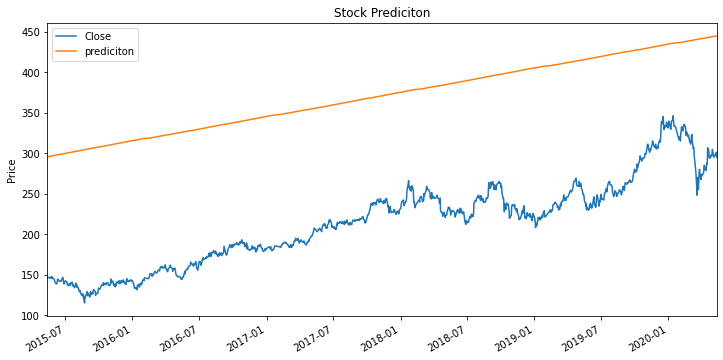

In [45]:
#start=0
#end=len(tw2330)
predictions = stepwise_fit.predict(len(tw2330))
tw2330['prediciton'] = predictions
title = 'Stock Prediciton'
ylabel='Price'
xlabel='' 

ax = tw2330['Close'].plot(legend=True,figsize=(12,6),title=title)
tw2330['prediciton'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [46]:
len(tw2330)

1219

In [0]:
training_set  = tw2330.iloc[0:1000, 3:4 ]

In [48]:
training_set.head()

,Close
Date,
2015-05-14,146.0
2015-05-15,146.5
2015-05-18,146.5
2015-05-19,146.5
2015-05-20,146.5


In [0]:
test_set  = tw2330.iloc[1000:, 3:4 ]

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
test_set_scaled = sc.transform(test_set)

In [0]:
import numpy as np
X_train = []
y_train = []
for i in range(60, 1000):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [53]:
X_train.shape

(940, 60)

In [54]:
y_train.shape

(940,)

In [55]:
#(資料長度, 時間長度, 維度)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(940, 60, 1)

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
regressor = tf.keras.models.Sequential()
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True)) 
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True)) 
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units = 1))

In [58]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [80]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, verbose=0, batch_size = 32)

KeyboardInterrupt: ignored

In [0]:
#test_set_scaled = sc.transform(test_set)
X_test = []
y_test = []
for i in range(60, 219):
    X_test.append(test_set_scaled[i-60:i, 0])
    y_test.append(test_set_scaled[i,0])

In [0]:
X_test = np.array(X_test)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
y_pred = regressor(X_test).numpy().flatten()

In [85]:
y_pred

array([0.94571143, 0.94641095, 0.9447857 , 0.94978744, 0.9558478 ,
       0.9632635 , 0.9640946 , 0.9589232 , 0.95384425, 0.9538615 ,
       0.95868   , 0.967566  , 0.98296523, 1.0130894 , 1.0347261 ,
       1.0316939 , 1.0202575 , 1.0171759 , 1.0415537 , 1.0553004 ,
       1.0737286 , 1.0958304 , 1.1146071 , 1.1115878 , 1.100314  ,
       1.0862732 , 1.0904429 , 1.0976219 , 1.0996236 , 1.0988619 ,
       1.0998749 , 1.1114221 , 1.1222751 , 1.121233  , 1.1167908 ,
       1.137397  , 1.1658629 , 1.1762772 , 1.1646888 , 1.1432369 ,
       1.120308  , 1.123245  , 1.1315713 , 1.132128  , 1.1381869 ,
       1.1540673 , 1.1735611 , 1.1735163 , 1.1569381 , 1.1407356 ,
       1.1304588 , 1.1289704 , 1.1432259 , 1.1484523 , 1.130748  ,
       1.1235272 , 1.1246762 , 1.1238381 , 1.1396055 , 1.1547306 ,
       1.1664023 , 1.1600926 , 1.1688633 , 1.2201853 , 1.2737312 ,
       1.2657483 , 1.2763689 , 1.2834451 , 1.2440089 , 1.2034287 ,
       1.2149959 , 1.2273785 , 1.2279735 , 1.2216873 , 1.23370

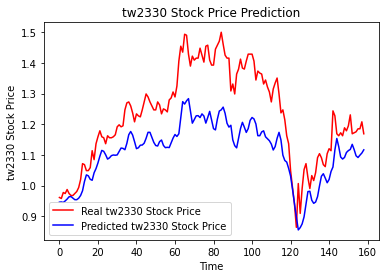

In [86]:
import matplotlib.pyplot as plt
plt.plot(y_test, color = 'red', label = 'Real tw2330 Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted tw2330 Stock Price')
plt.title('tw2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('tw2330 Stock Price')
plt.legend()
plt.show()

In [0]:
y_pred2 = sc.inverse_transform(y_pred.reshape(-1,1))
#y_test2 = sc.inverse_transform(y_test)

In [0]:
y_test2 = sc.inverse_transform(np.array(y_test).reshape(-1,1))

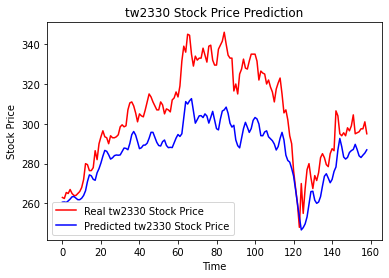

In [89]:
import matplotlib.pyplot as plt
plt.plot(y_test2, color = 'red', label = 'Real tw2330 Stock Price')
plt.plot(y_pred2, color = 'blue', label = 'Predicted tw2330 Stock Price')
plt.title('tw2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [0]:
y_pred = regressor(X_train).numpy().flatten()

In [0]:
y_pred2 = sc.inverse_transform(y_pred.reshape(-1,1))

In [0]:
y_train2 = sc.inverse_transform(np.array(y_train).reshape(-1,1))

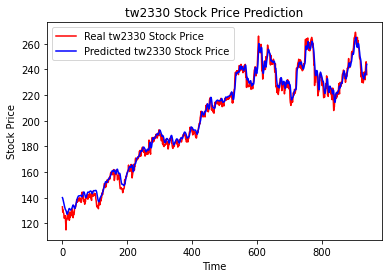

In [93]:
import matplotlib.pyplot as plt
plt.plot(y_train2, color = 'red', label = 'Real tw2330 Stock Price')
plt.plot(y_pred2, color = 'blue', label = 'Predicted tw2330 Stock Price')
plt.title('tw2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()